In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def read_dataset(fname):
    # 指定索引
    data = pd.read_csv(fname) 
    
    # 刪除不需要的欄位
    data.columns=['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba','bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']


    data.drop(['al', 'wc', 'rbc', 'sod', 'pot', 'hemo', 'pcv', 'rc', 'sg', 'pc', 'su', 'bgr', 'bu'], axis=1, inplace=True)
    
    list_name = ['age', 'bp', 'pcc', 'ba', 'sc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
    for i in list_name:
        data[i] = data[i].replace('?', None).replace(' yes','yes')
        
    return data
    
def Feature_Processing(df, col):

    labels = df[col].unique().tolist()
    df[col] = df[col].apply(lambda n: labels.index(n))
    return df

train = read_dataset('chronic_kidney_disease.csv')

list_Feature = ['pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
[Feature_Processing(train, i) for i in list_Feature] #

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     399 non-null    object
 1   bp      399 non-null    object
 2   pcc     399 non-null    int64 
 3   ba      399 non-null    int64 
 4   sc      399 non-null    object
 5   htn     399 non-null    int64 
 6   dm      399 non-null    int64 
 7   cad     399 non-null    int64 
 8   appet   399 non-null    int64 
 9   pe      399 non-null    int64 
 10  ane     399 non-null    int64 
 11  class   399 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 37.5+ KB


In [3]:
train.head()

,age,bp,pcc,ba,sc,htn,dm,cad,appet,pe,ane,class
0,7,50,0,0,0.8,0,0,0,0,0,0,0
1,62,80,0,0,1.8,0,1,0,1,0,1,0
2,48,70,1,0,3.8,1,0,0,1,1,1,0
3,51,80,0,0,1.4,0,0,0,0,0,0,0
4,60,90,0,0,1.1,1,1,0,0,1,0,0


In [4]:
from sklearn.model_selection import train_test_split

y = train['class'].values
X = train.drop(['class'], axis=1).values

#切分訓練與驗證資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('train dataset: {0}; test dataset: {1}'.format(
    X_train.shape, X_test.shape))

train dataset: (319, 11); test dataset: (80, 11)


In [5]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

#發生過擬合現象

train score: 0.9968652037617555; test score: 0.975


best param: 5; best score: 0.975


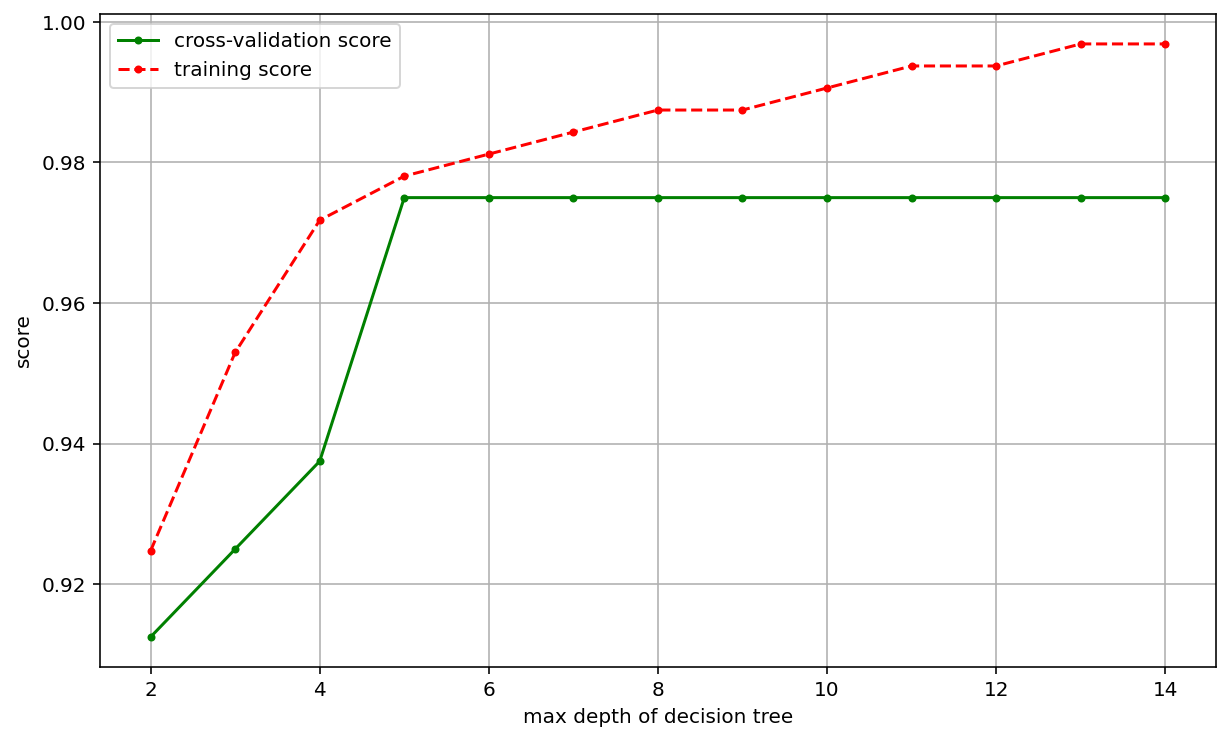

In [6]:
from sklearn.tree import DecisionTreeClassifier

#調整參數max_depth
def cv_score(d):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

#設定深度2~15
depths = range(2, 15)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

#找出驗證資料集分數最高的索引
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = depths[best_score_index]
#列印最好的參數
print('best param: {0}; best score: {1}'.format(best_param, best_score))

plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.xlabel('max depth of decision tree')
plt.ylabel('score')
plt.plot(depths, cv_scores, '.g-', label='cross-validation score')
plt.plot(depths, tr_scores, '.r--', label='training score')
plt.legend()


best param: 0.0; best score: 0.975


C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_c

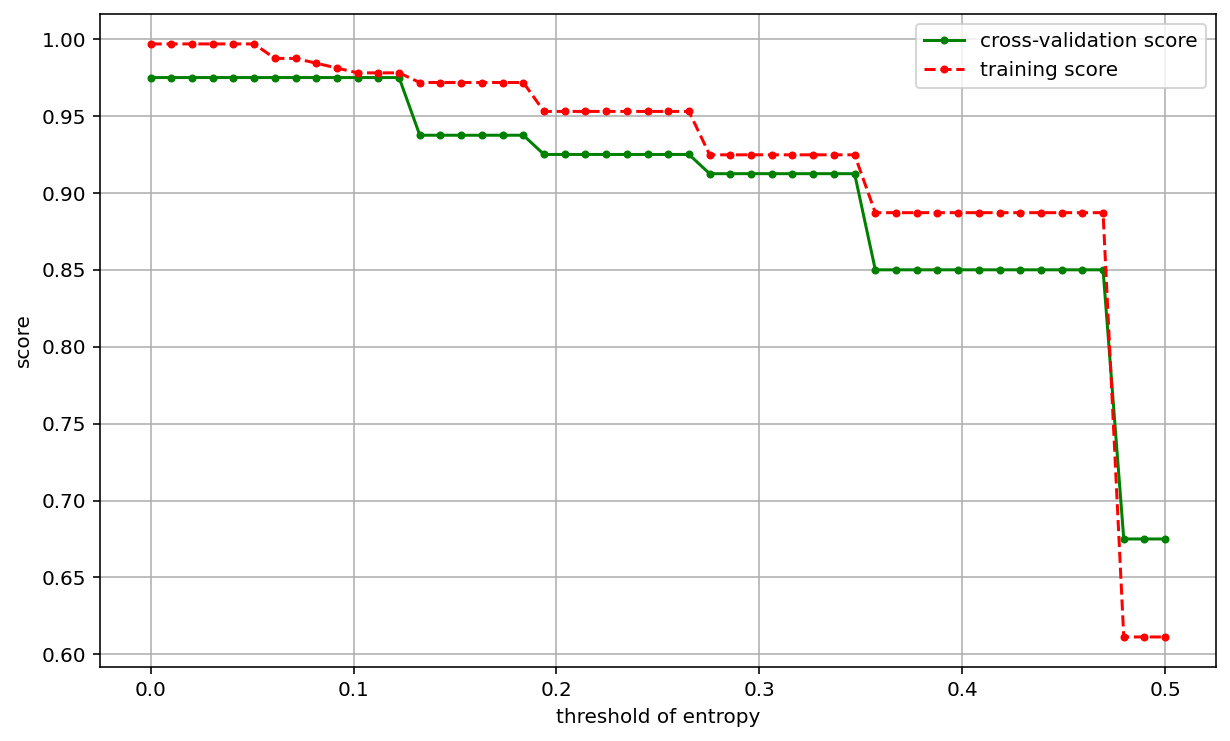

In [7]:
#利用基尼不純度
#設定閥值參數(min_impurity_split)，當information gain低於這個閥值時，則不進行分歧
def cv_score(val):
    clf = DecisionTreeClassifier(criterion='gini', min_impurity_split=val)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

# 指定閥值範圍
values = np.linspace(0, 0.5, 50)
scores = [cv_score(v) for v in values]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

# 找出分數最高的參數
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = values[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

# 畫圖
plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.xlabel('threshold of entropy')
plt.ylabel('score')
plt.plot(values, cv_scores, '.g-', label='cross-validation score')
plt.plot(values, tr_scores, '.r--', label='training score')
plt.legend()

In [8]:
def plot_curve(train_sizes, cv_results, xlabel):
    train_scores_mean = cv_results['mean_train_score']
    train_scores_std = cv_results['std_train_score']
    test_scores_mean = cv_results['mean_test_score']
    test_scores_std = cv_results['std_test_score']
    plt.figure(figsize=(10, 6), dpi=144)
    plt.title('parameters turning')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '.--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '.-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_c

C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_c

C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_c

best param: {'min_impurity_split': 0.04081632653061224}
best score: 0.9648417721518987


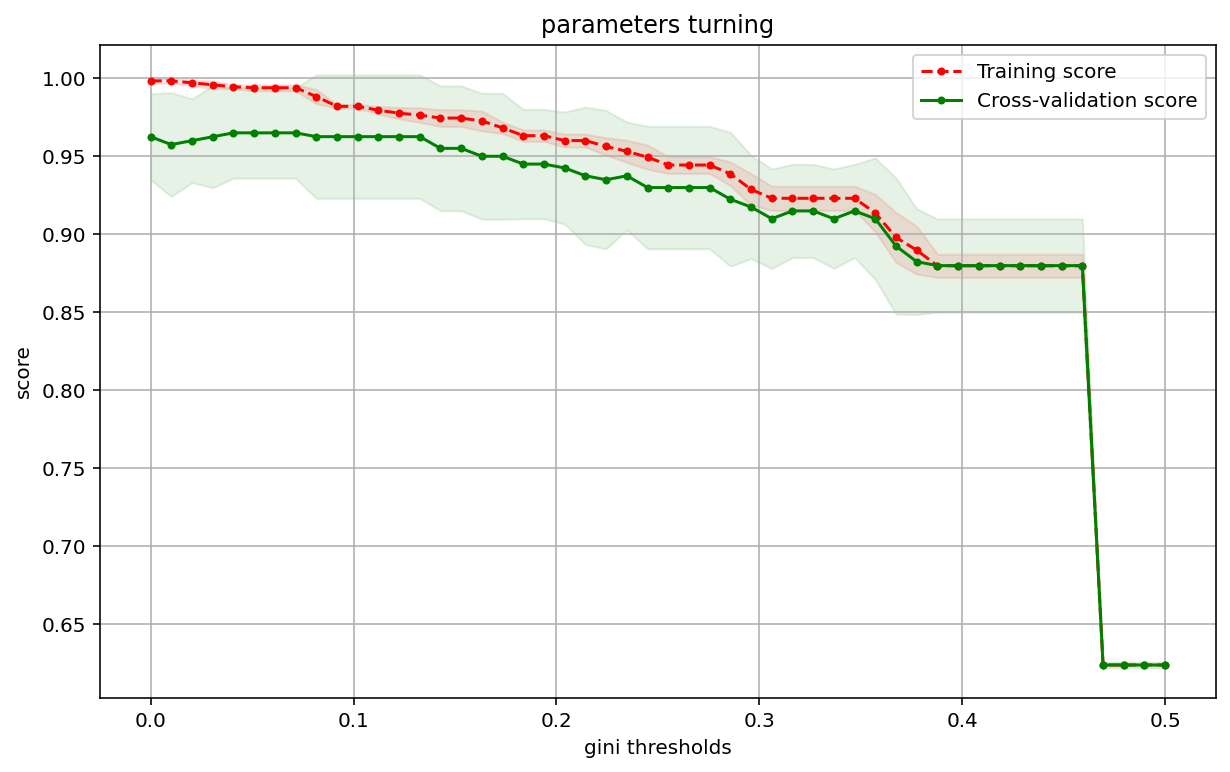

In [9]:
#透過GridSearchCV進行
#優點: 1. 內建交驗驗證，讓資料樣本穩定 2. 可以同時設定多個參數
from sklearn.model_selection import GridSearchCV

thresholds = np.linspace(0, 0.5, 50)
param_grid = {'min_impurity_split': thresholds}

#每次計算時，都把資料切成5份，拿其中一份做為交叉驗證資料集，其他做為訓練資料集
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
clf.fit(X, y)
print("best param: {0}\nbest score: {1}".format(clf.best_params_, 
                                                clf.best_score_))

plot_curve(thresholds, clf.cv_results_, xlabel='gini thresholds')

In [10]:
#進行多個參數設定
from sklearn.model_selection import GridSearchCV

entropy_thresholds = np.linspace(0, 1, 50)
gini_thresholds = np.linspace(0, 0.5, 50)

#ID3
param_grid = [{'criterion': ['entropy'], 
               'min_impurity_split': entropy_thresholds},
              {'criterion': ['gini'], 
               'min_impurity_split': gini_thresholds},
              {'max_depth': range(2, 10)},
              {'min_samples_split': range(2, 30, 2)}]

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(X, y)
print("best param: {0}\nbest score: {1}".format(clf.best_params_, 
                                                clf.best_score_))

C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_c

C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_c

C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_c

C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_c

best param: {'max_depth': 5}
best score: 0.9699050632911392


In [11]:
clf = DecisionTreeClassifier(criterion='entropy', min_impurity_split=0.5306122448979591)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

from sklearn import tree

with open("chronic_kidney_disease.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

train score: 0.9529780564263323; test score: 0.925


C:\Users\emily\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
